In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
import numpy as np

import camb
from camb import model, initialpower
import pandas as pd

plt.rcdefaults()

In [8]:
snap_index = 0

In [9]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location(
    "spectra", "../shared/spectra.py")
spectra = importlib.util.module_from_spec(spec)
sys.modules["spectra"] = spectra
spec.loader.exec_module(spectra)

In [10]:
omega_index = 2 # while we debug, we confine our attention to just one value
onh2 = spectra.omegas_nu[omega_index]
onh2_str = spectra.omnu_strings[omega_index]

In [11]:
# It's a waste of time to consider all of the omegas and snapshots, so we're
# making heavy use of skips.
spec_sims = spectra.better_battery(spectra.omegas_nu, spectra.omnu_strings,
    skips_omega = [0, 1], skips_model=[8], skips_snapshot=[1, 2, 3],
    h_units=False)

In [12]:
#data = spec_sims[onh2_str]
data = spectra.powernu3[onh2_str]
#dTitle = "Lukas"
dTitle = "Ariel III"

fig, axs = plt.subplots()
spectra.model_ratios_true(
    4, spec_sims[onh2_str], axs, massive='x', skips=[7, 8], omnuh2_str=onh2_str,
    title="Simulation attempt");

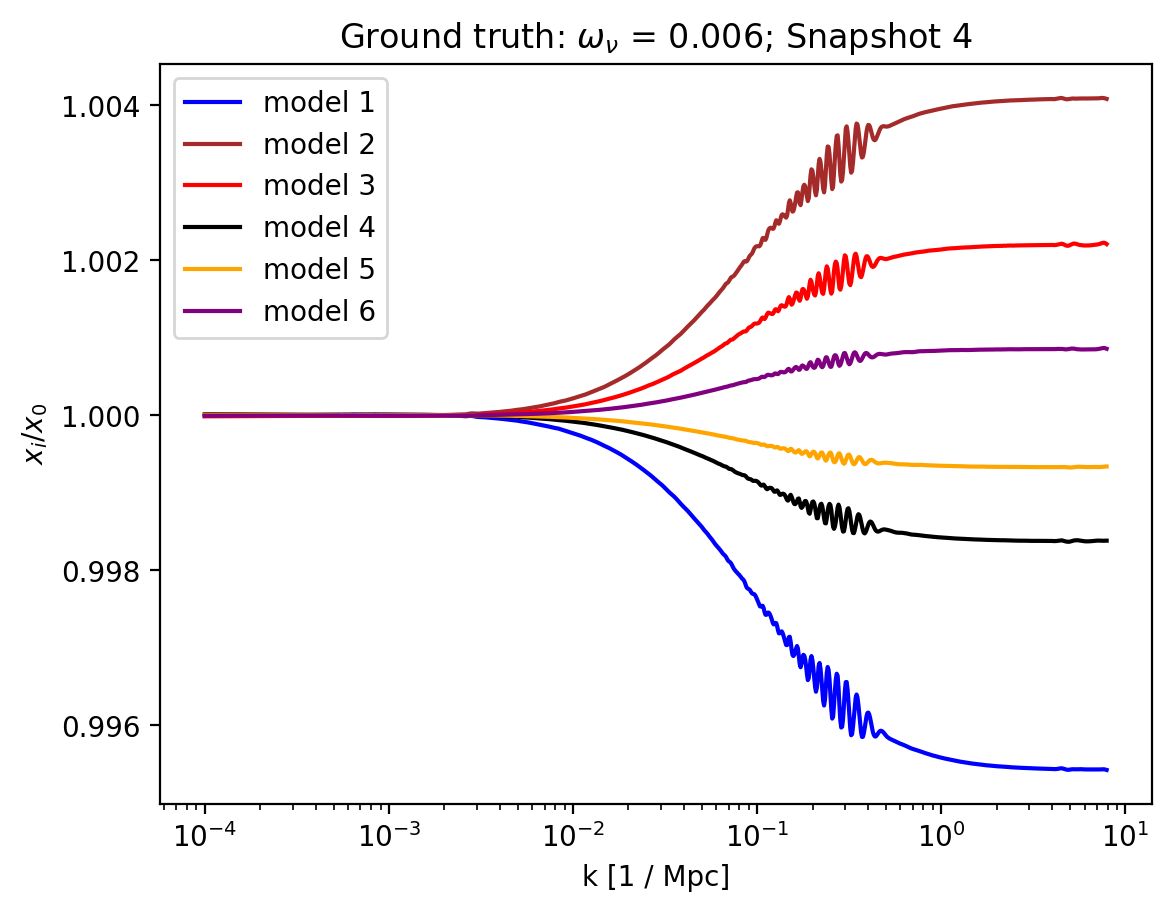

In [13]:
fig, axs = plt.subplots()
spectra.model_ratios_true(4, spectra.powernu[onh2_str], axs,
    massive='x', skips=[7, 8], omnuh2_str=onh2_str);

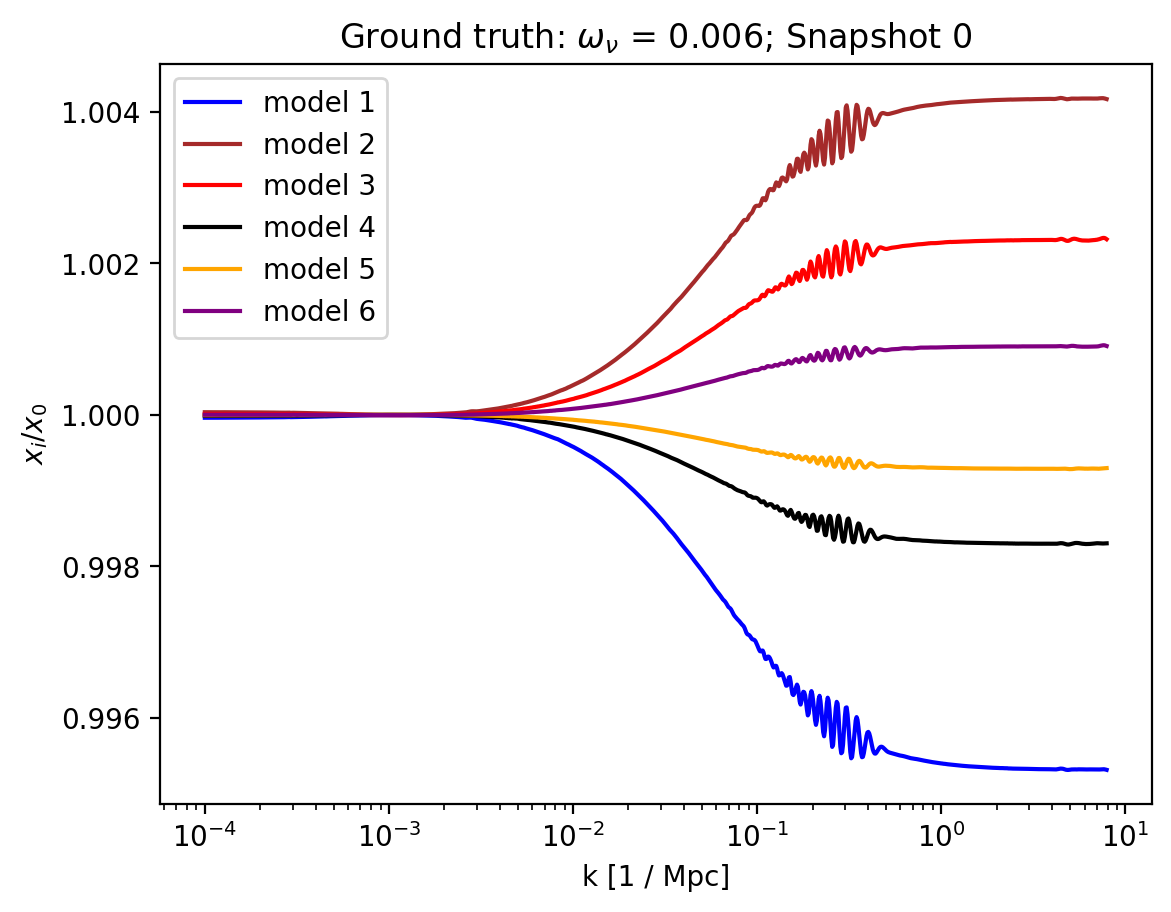

In [14]:
fig, axs = plt.subplots()
ks, rats = spectra.model_ratios_true(snap_index, data, axs,
    massive='x', skips=[7, 8], omnuh2_str=onh2_str);

In [15]:
# Be careful with the indexing here; rats[0] is the ratio of model 1 to model 0
true_asymptotes = np.array([rats[i][len(rats[i]) - 1] for i in range(len(rats))])
zc_asymptotes = true_asymptotes - 1

In [16]:
true_asymptotes

array([0.99531417, 1.00417019, 1.00231986, 0.99830498, 0.99929823,
       1.00091013])

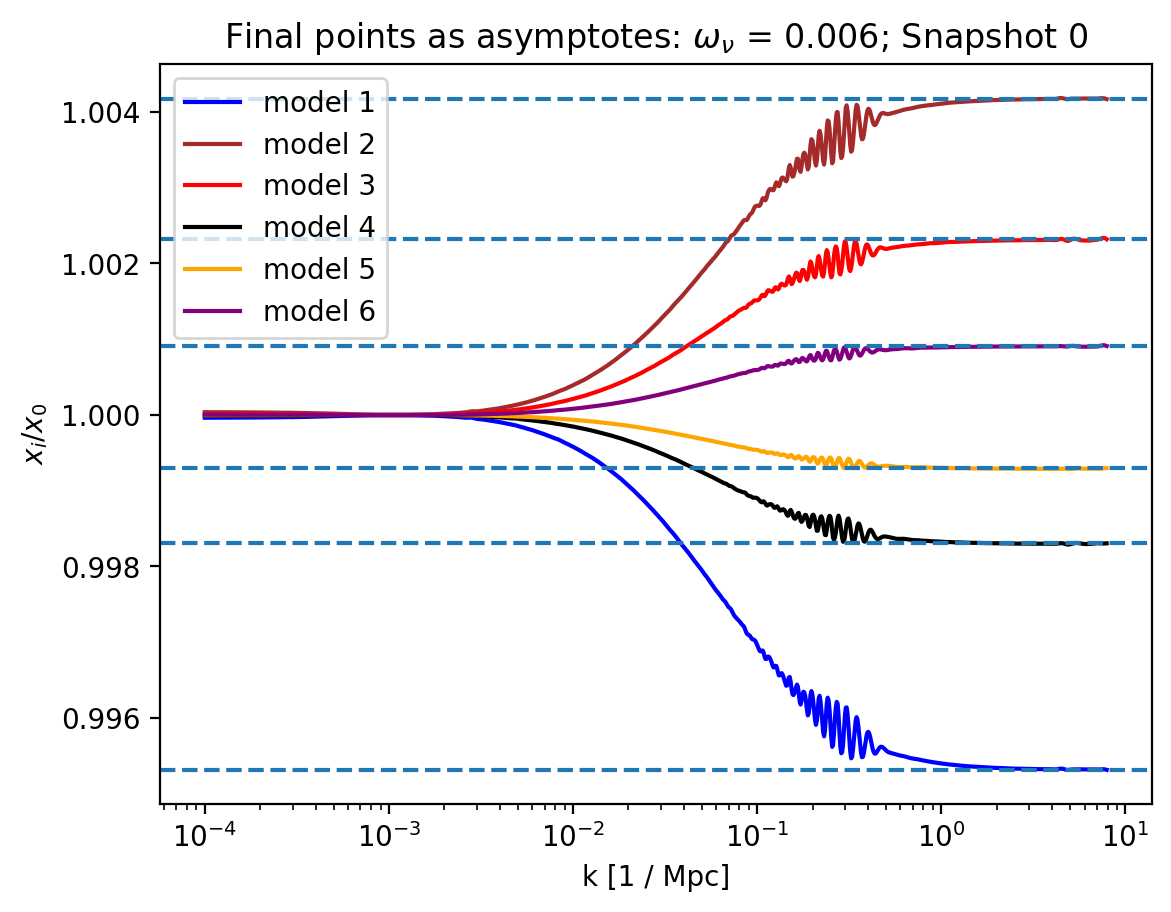

In [17]:
fig, axs = plt.subplots()
spectra.model_ratios_true(snap_index, data, axs,
    massive='x', skips=[7, 8], omnuh2_str=onh2_str,
    title="Final points as asymptotes")
for asymptote in true_asymptotes:
    axs.axhline(asymptote, linestyle='--')

y-intercept for this fit is 0.9730217497565392
slope for this fit is 4.221078320231252
[5.24465823e-08 3.65331164e-08 8.30584718e-10 1.32476868e-08
 2.54374899e-08 1.36279380e-08]
Reduced chi squared value for this fit: 2.370546617680162e-08


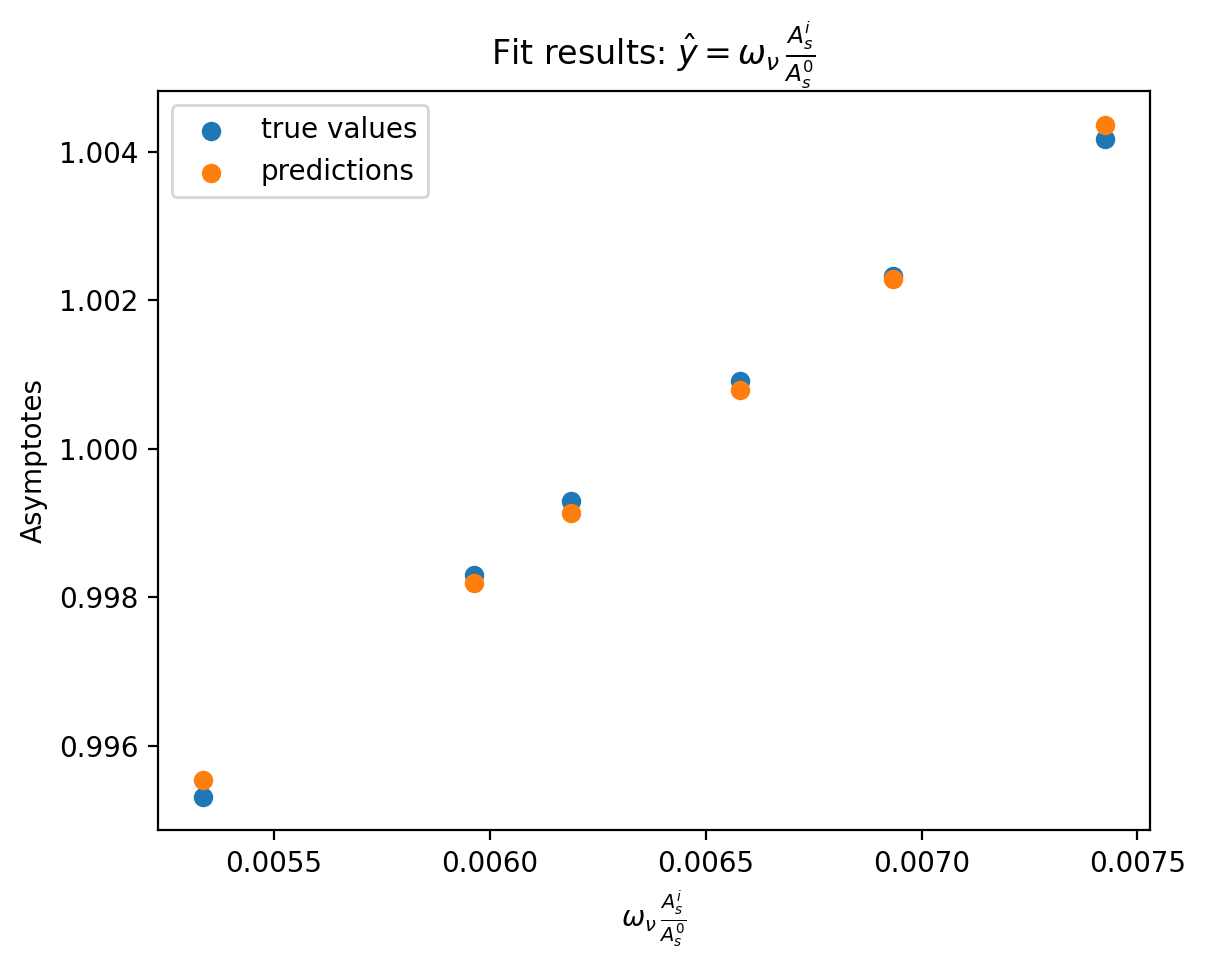

In [18]:
A_s = [spectra.cosm.loc[i]["A_s"] for i in range(7)]
from numpy.polynomial.polynomial import polyfit

x1 = onh2 * (A_s[1:] / A_s[0])
model_desc_1 = r"\omega_\nu \, \frac{A_s^i}{A_s^0}$"

plt.scatter(x1, true_asymptotes, label="true values")

b1, m1 = polyfit(x1, true_asymptotes, 1)
pred1 = m1 * x1 + b1 

plt.scatter(x1, pred1, label="predictions")
print("y-intercept for this fit is", b1)
print("slope for this fit is", m1)
print(np.square(true_asymptotes - pred1))

plt.ylabel("Asymptotes")
plt.xlabel("$" + model_desc_1)
plt.title(r"Fit results: $\hat{y} = " + model_desc_1)
plt.legend()

chis1 = (true_asymptotes - pred1) ** 2 / pred1
red_chisq1 = sum(chis1) / len(x1)
print("Reduced chi squared value for this fit:", red_chisq1)

In [19]:
pred1

array([0.99554318, 1.00436132, 1.00229104, 0.99818988, 0.99913874,
       1.00079339])

In [20]:
from sklearn.linear_model import LinearRegression
reg_b_centered_noyint = LinearRegression()
reg_b_centered_noyint.fit_intercept=False
X = x1.reshape(-1, 1)
fit_b_centered_noyint = reg_b_centered_noyint.fit(X, zc_asymptotes)
m_centered_noyint = fit_b_centered_noyint.coef_[0]
b_centered_noyint = fit_b_centered_noyint.intercept_
print("slope for this fit is", m_centered_noyint, b_centered_noyint)

slope for this fit is 0.054607927403469966 0.0


In [21]:
reg_b_centered_yint = LinearRegression()
reg_b_centered_yint.fit_intercept=True
X = x1.reshape(-1, 1)
fit_b_centered_yint = reg_b_centered_yint.fit(X, zc_asymptotes)
m_centered_yint = fit_b_centered_yint.coef_[0]
b_centered_yint = fit_b_centered_yint.intercept_
print("slope for this fit is", m_centered_yint, b_centered_yint)

slope for this fit is 4.221078320231075 -0.026978250243459484


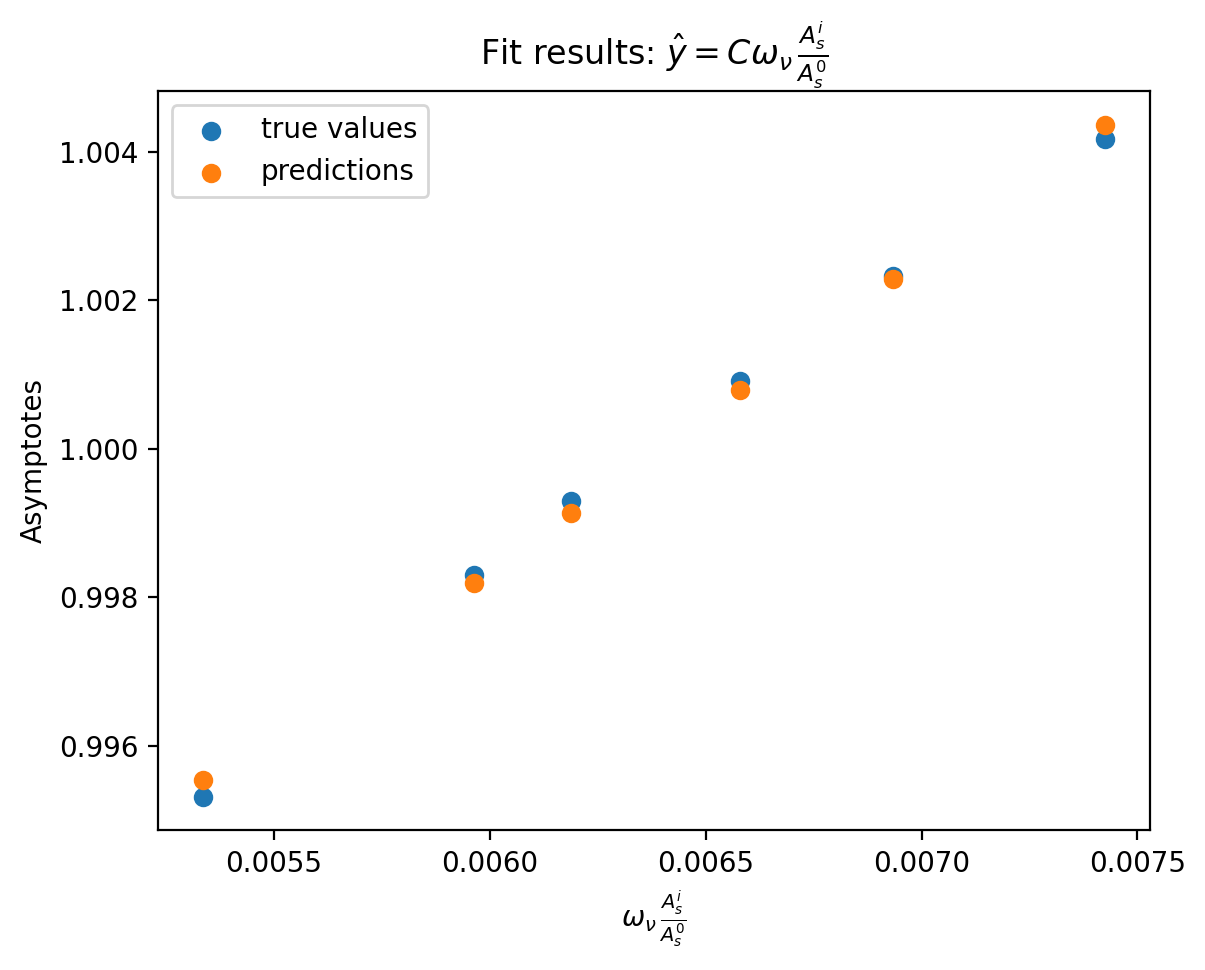

In [22]:
plt.scatter(x1, true_asymptotes, label="true values")
plt.scatter(x1, m1 * onh2 * (A_s[1:] / A_s[0]) + b1, label="predictions")

plt.ylabel("Asymptotes")
plt.xlabel("$" + model_desc_1)
plt.title(r"Fit results: $\hat{y} = C" + model_desc_1)
plt.legend()

In [23]:
C = m1

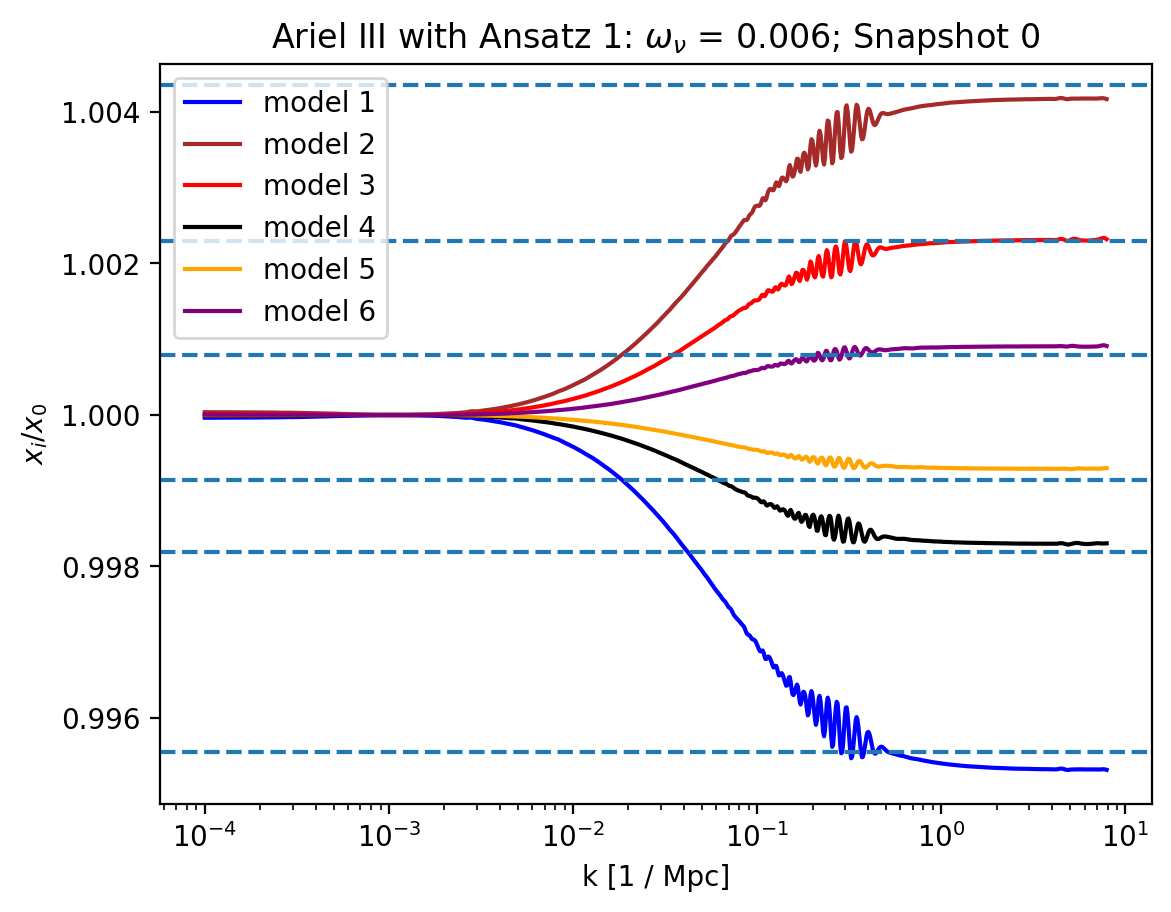

In [24]:
fig, axs = plt.subplots()
spectra.model_ratios_true(snap_index, data, axs,
    massive='x', skips=[7, 8], omnuh2_str=onh2_str,
    title=dTitle + " with Ansatz 1");
for i in range(len(true_asymptotes)):
    axs.axhline(m1 * x1[i] + b1, linestyle='--')

y-intercept for this fit is 0.9462561523286144
slope for this fit is 8.444108142425103
Reduced chi squared value for this fit: 6.104971761390347e-09


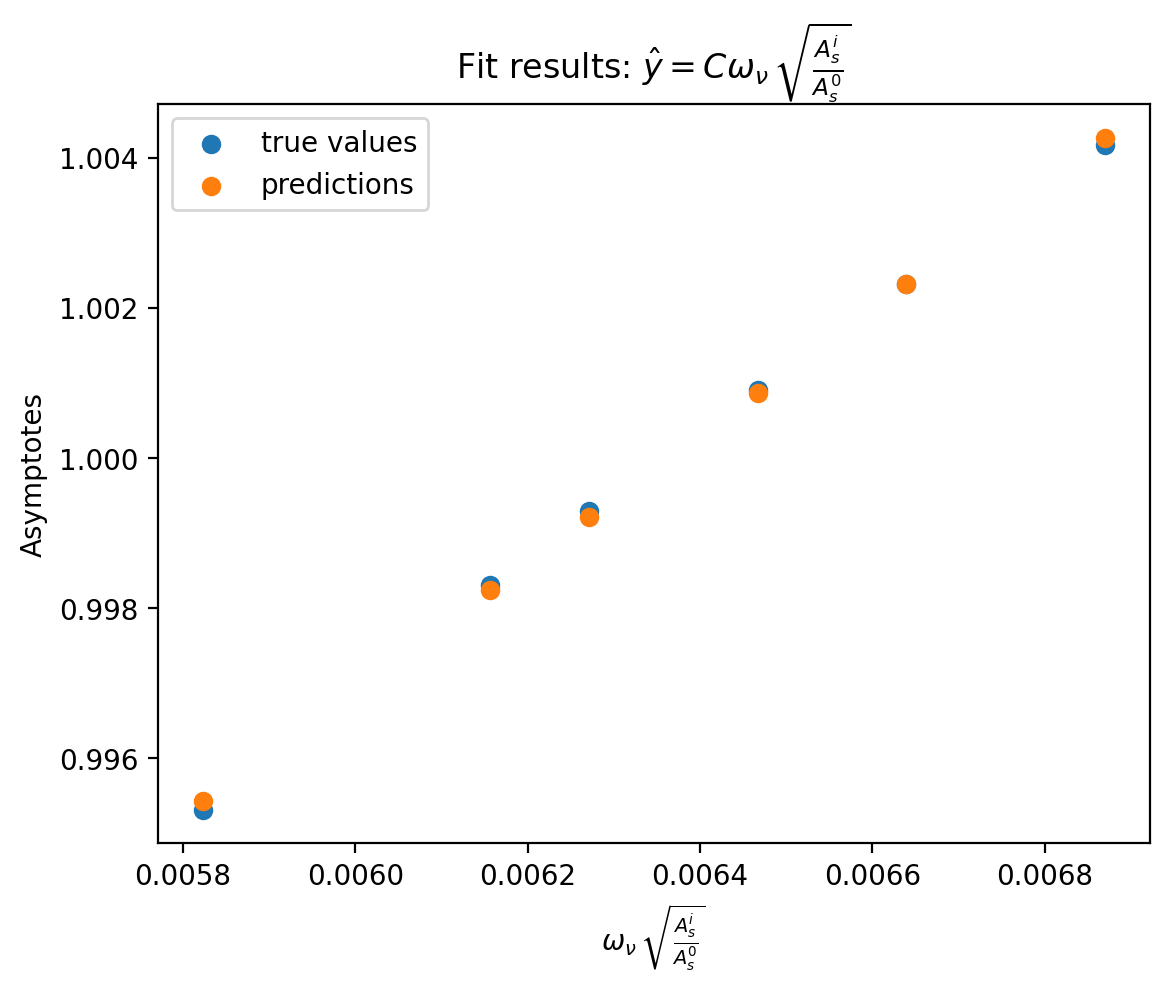

In [25]:
x2 = onh2 * np.sqrt(A_s[1:] / A_s[0])
model_desc_2 = r"\omega_\nu \, \sqrt{\frac{A_s^i}{A_s^0}}$"

plt.scatter(x2, true_asymptotes, label="true values")

b2, m2 = polyfit(x2, true_asymptotes, 1)

pred2 = m2 * x2 + b2
plt.scatter(x2, pred2, label="predictions")

print("y-intercept for this fit is", b2)
print("slope for this fit is", m2)

plt.ylabel("Asymptotes")
plt.xlabel("$" + model_desc_2)
plt.title(r"Fit results: $\hat{y} = C" + model_desc_2)
plt.legend()

chis2 = (true_asymptotes - pred2) ** 2 / pred2
red_chisq2 = sum(chis2) / len(x2)
print("Reduced chi squared value for this fit:", red_chisq2)

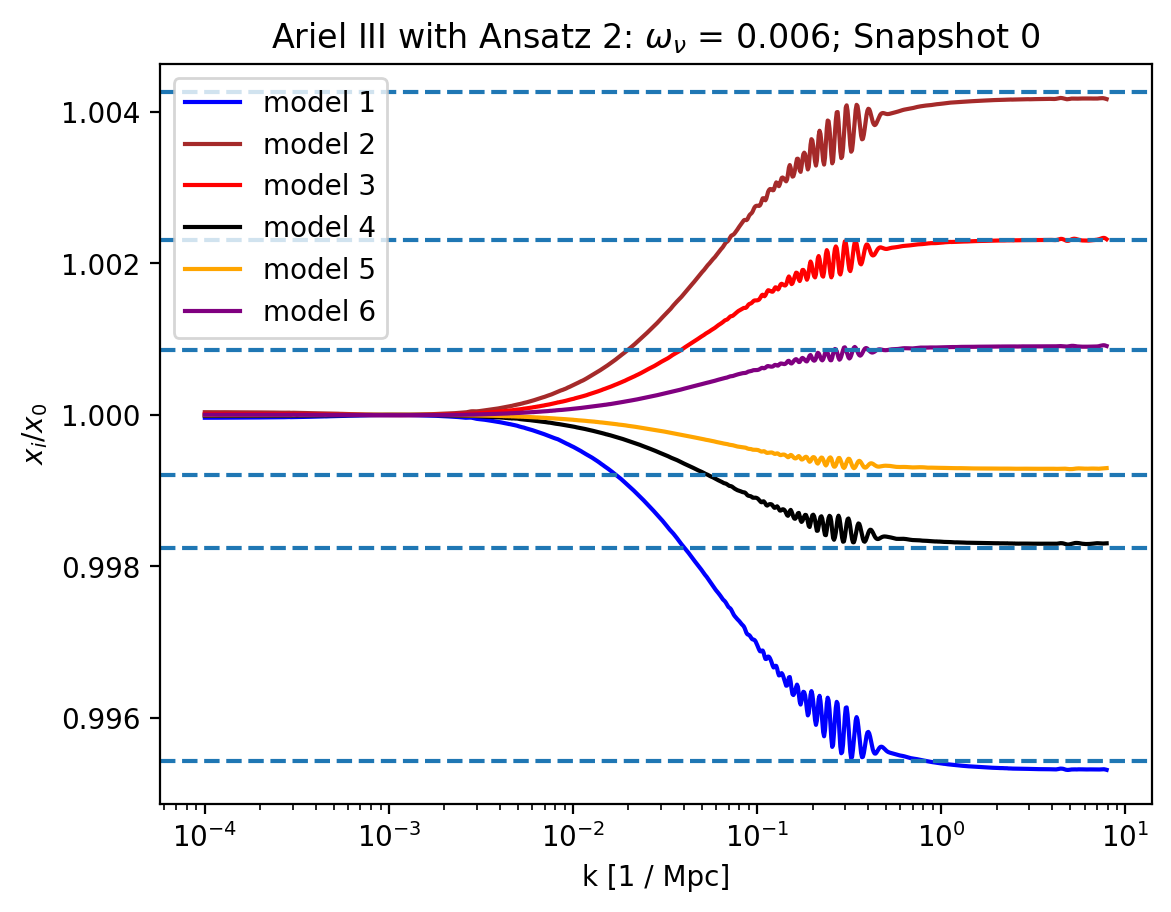

In [26]:
fig, axs = plt.subplots()
spectra.model_ratios_true(snap_index, data, axs,
    massive='x', skips=[7, 8], omnuh2_str=onh2_str,
    title=dTitle + " with Ansatz 2");

for i in range(len(true_asymptotes)):
    axs.axhline(m2 * x2[i] + b2, \
        linestyle='--')

y-intercept for this fit is 0.9194999209456328
slope for this fit is 12.65771406160271
Reduced chi squared value for this fit: 2.8171159222149675e-09


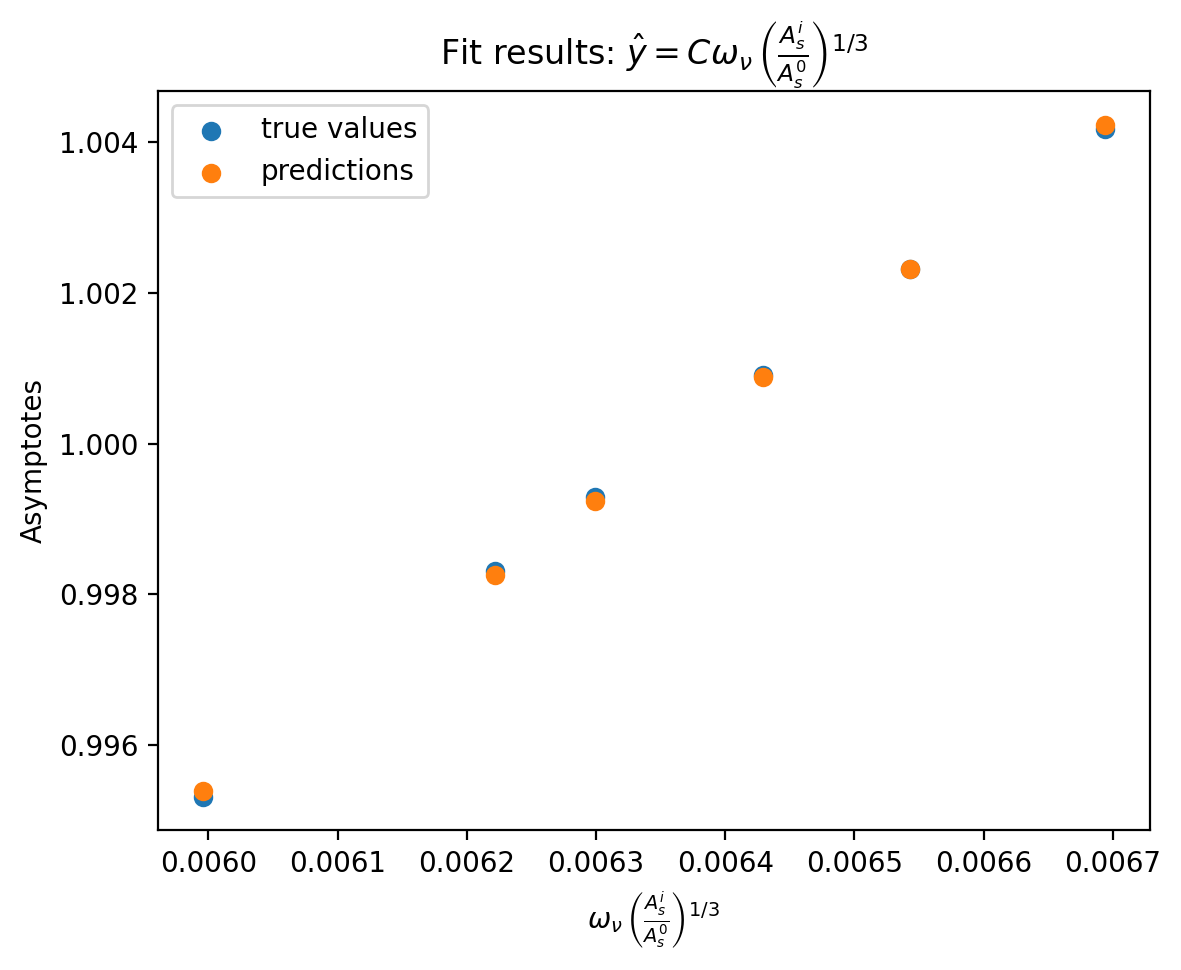

In [27]:
x3 = onh2 * np.power(A_s[1:] / A_s[0], 1/3)
model_desc_3 = r"\omega_\nu \, \left( \frac{A_s^i}{A_s^0} \right)^{1/3}$"

plt.scatter(x3, true_asymptotes, label="true values")

b3, m3 = polyfit(x3, true_asymptotes, 1)

pred3 = m3 * x3 + b3
plt.scatter(x3, pred3, label="predictions")

print("y-intercept for this fit is", b3)
print("slope for this fit is", m3)

plt.ylabel("Asymptotes")
plt.xlabel("$" + model_desc_3)
plt.title(r"Fit results: $\hat{y} = C" + model_desc_3)
plt.legend()

chis3 = (true_asymptotes - pred3) ** 2 / pred3
red_chisq3 = sum(chis3) / len(x3)
print("Reduced chi squared value for this fit:", red_chisq3)

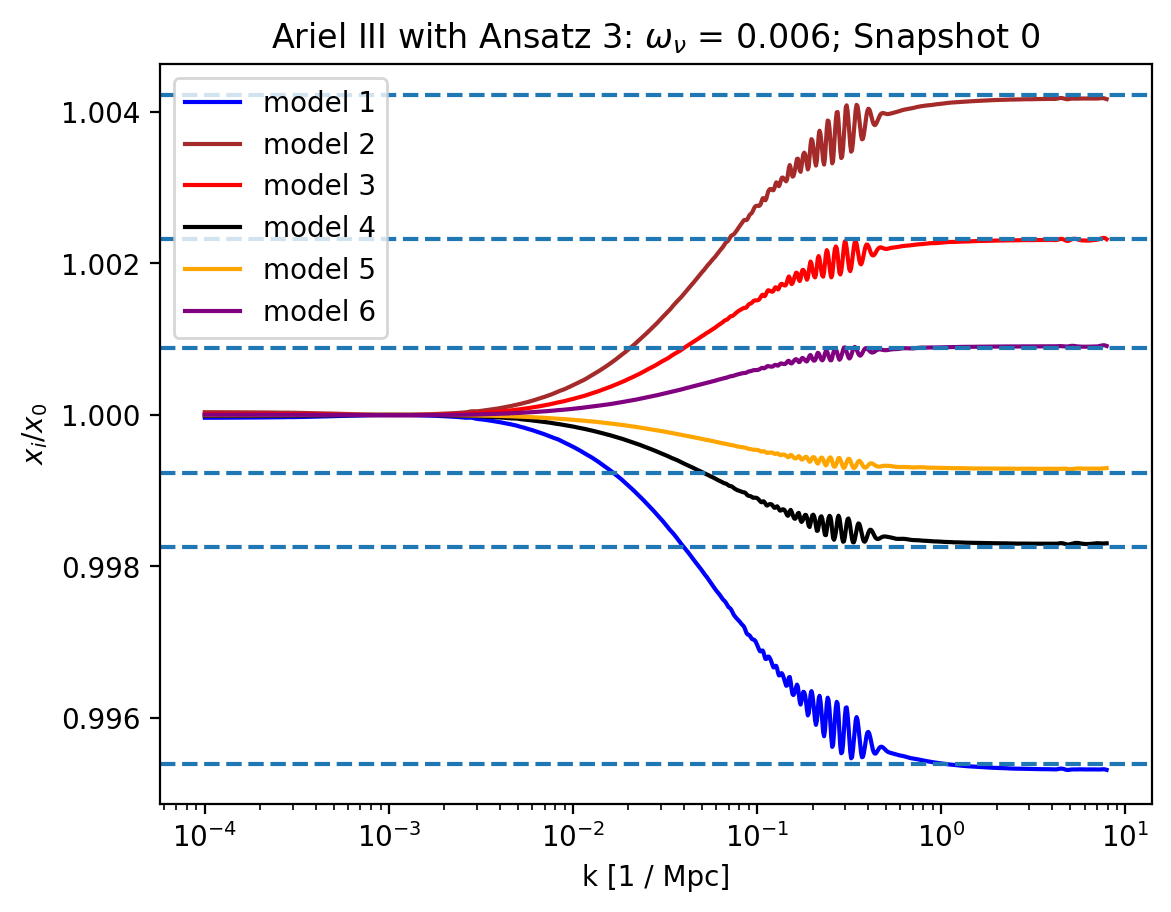

In [28]:
fig, axs = plt.subplots()
spectra.model_ratios_true(snap_index, data, axs,
    massive='x', skips=[7, 8], omnuh2_str=onh2_str,
    title=dTitle + " with Ansatz 3")
for i in range(len(true_asymptotes)):
    axs.axhline(m3 * x3[i] + b3, linestyle='--')

y-intercept for this fit is 0.892745987963015
slope for this fit is 16.868958284129864
Reduced chi squared value for this fit: 1.6612825399172065e-09


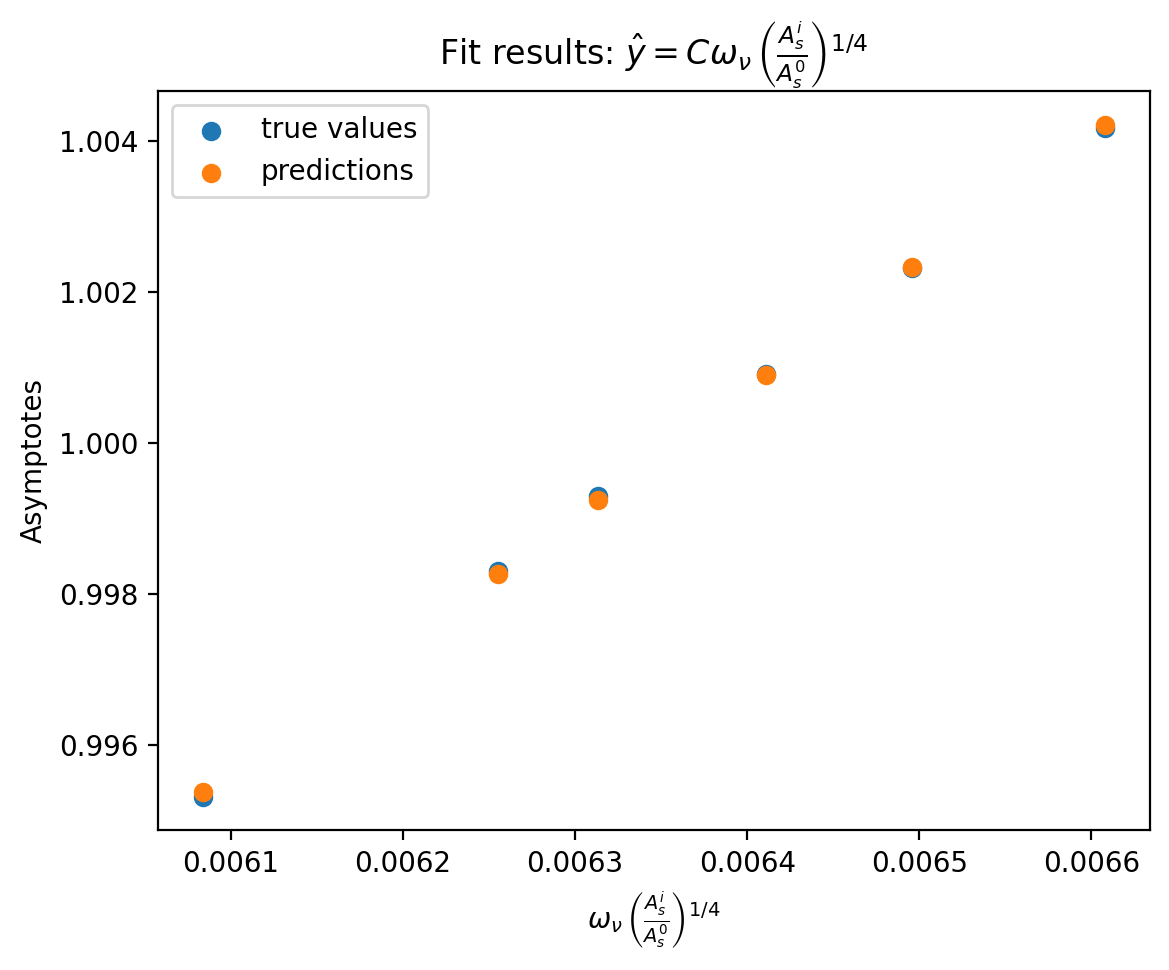

In [29]:
x4 = onh2 * np.power(A_s[1:] / A_s[0], 1/4)
model_desc_4 = r"\omega_\nu \, \left( \frac{A_s^i}{A_s^0} \right)^{1/4}$"

plt.scatter(x4, true_asymptotes, label="true values")

b4, m4 = polyfit(x4, true_asymptotes, 1)

pred4 = m4 * x4 + b4
plt.scatter(x4, pred4, label="predictions")

print("y-intercept for this fit is", b4)
print("slope for this fit is", m4)

plt.ylabel("Asymptotes")
plt.xlabel("$" + model_desc_4)
plt.title(r"Fit results: $\hat{y} = C" + model_desc_4)
plt.legend()

chis4 = (true_asymptotes - pred4) ** 2 / pred4
red_chisq4 = sum(chis4) / len(x4)
print("Reduced chi squared value for this fit:", red_chisq4)

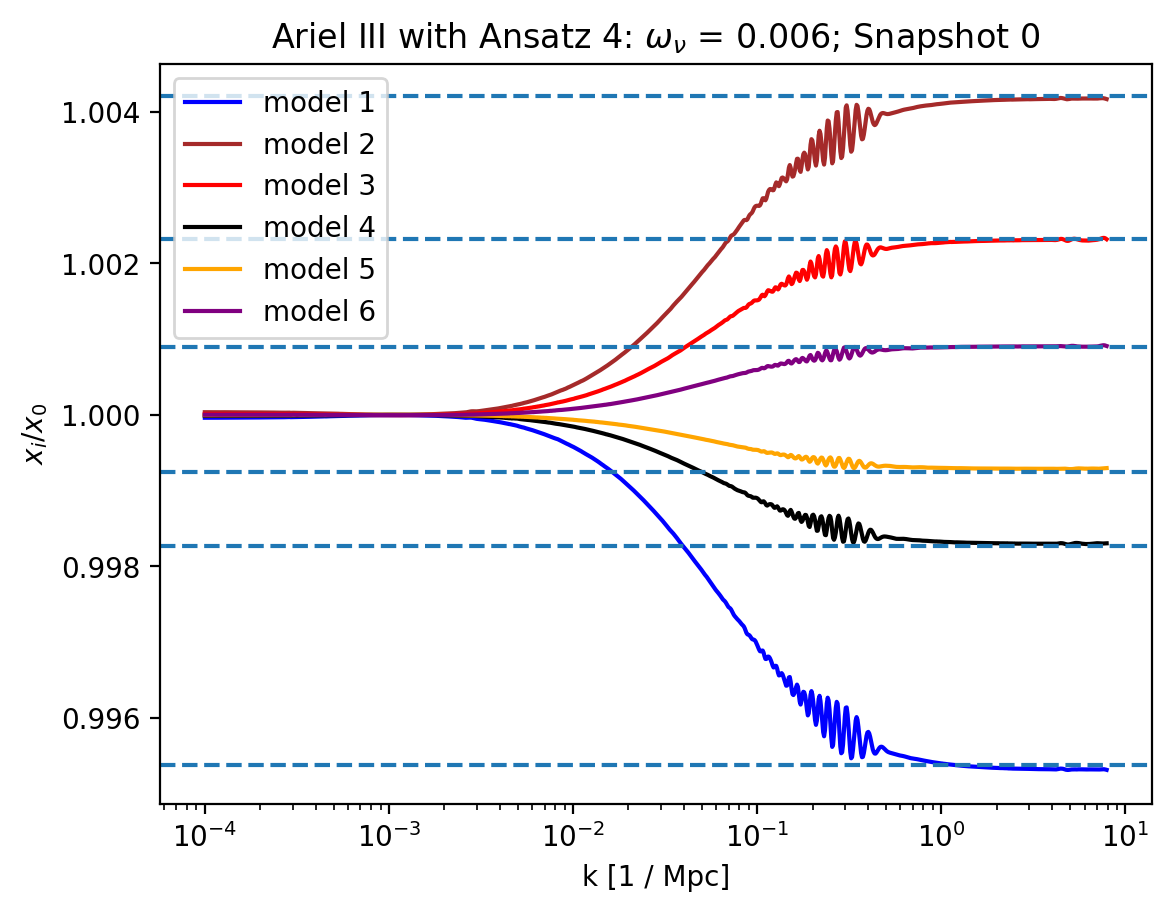

In [30]:
fig, axs = plt.subplots()
spectra.model_ratios_true(snap_index, data, axs,
    massive='x', skips=[7, 8], omnuh2_str=onh2_str,
    title=dTitle + " with Ansatz 4")
for i in range(len(true_asymptotes)):
    axs.axhline(m4 * x4[i] + b4, linestyle='--')

y-intercept for this fit is 0.8659929657141492
slope for this fit is 21.0792580956866
Reduced chi squared value for this fit: 1.1243692113651678e-09


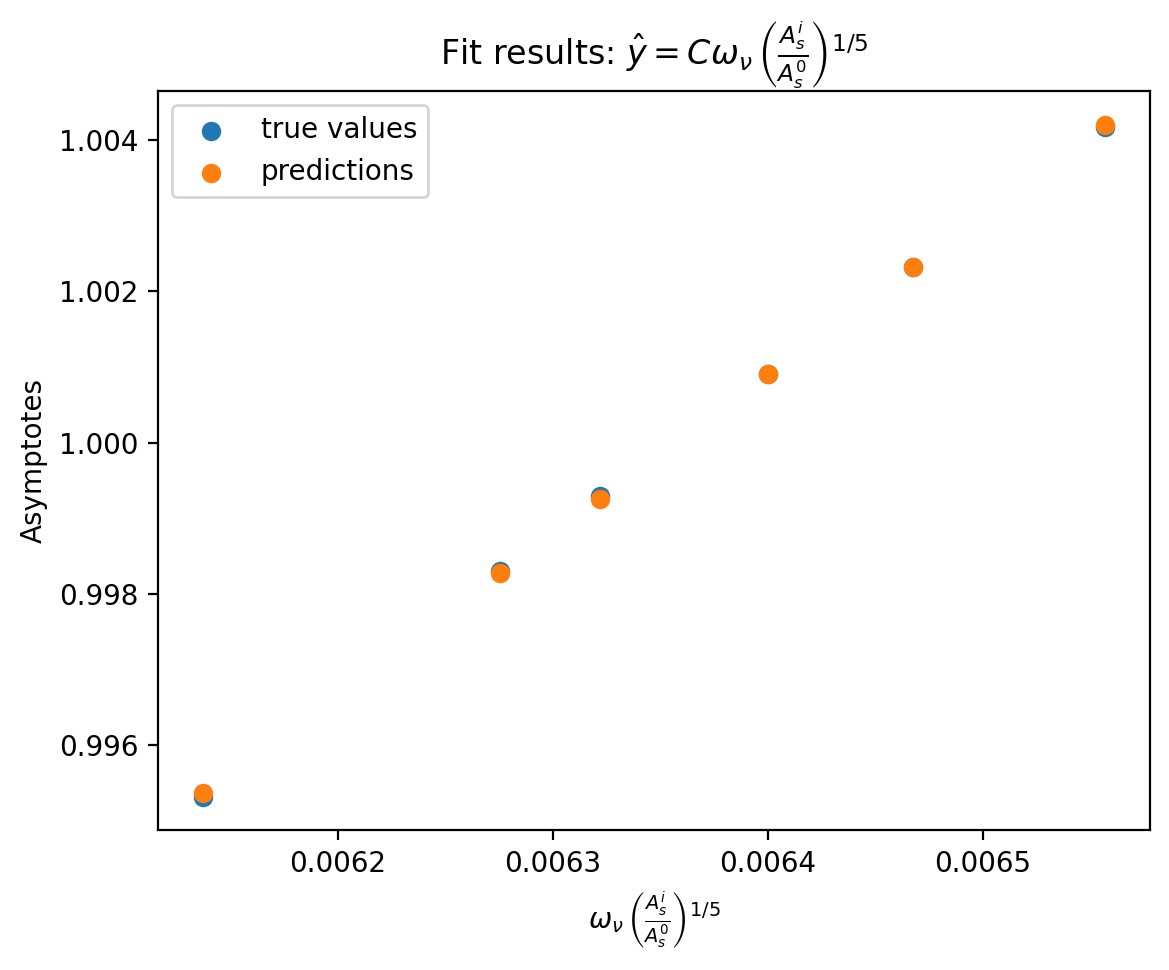

In [31]:
x5 = onh2 * np.power(A_s[1:] / A_s[0], 1/5)
model_desc_5 = r"\omega_\nu \, \left( \frac{A_s^i}{A_s^0} \right)^{1/5}$"

plt.scatter(x5, true_asymptotes, label="true values")

b5, m5 = polyfit(x5, true_asymptotes, 1)

pred5 = m5 * x5 + b5
plt.scatter(x5, pred5, label="predictions")

print("y-intercept for this fit is", b5)
print("slope for this fit is", m5)

plt.ylabel("Asymptotes")
plt.xlabel("$" + model_desc_5)
plt.title(r"Fit results: $\hat{y} = C" + model_desc_5)
plt.legend()

chis5 = (true_asymptotes - pred5) ** 2 / pred5
red_chisq5 = sum(chis5) / len(x5)
print("Reduced chi squared value for this fit:", red_chisq5)

In [32]:
pred5

array([0.99536397, 1.00420198, 1.00232571, 0.99827107, 0.99925375,
       1.00090107])

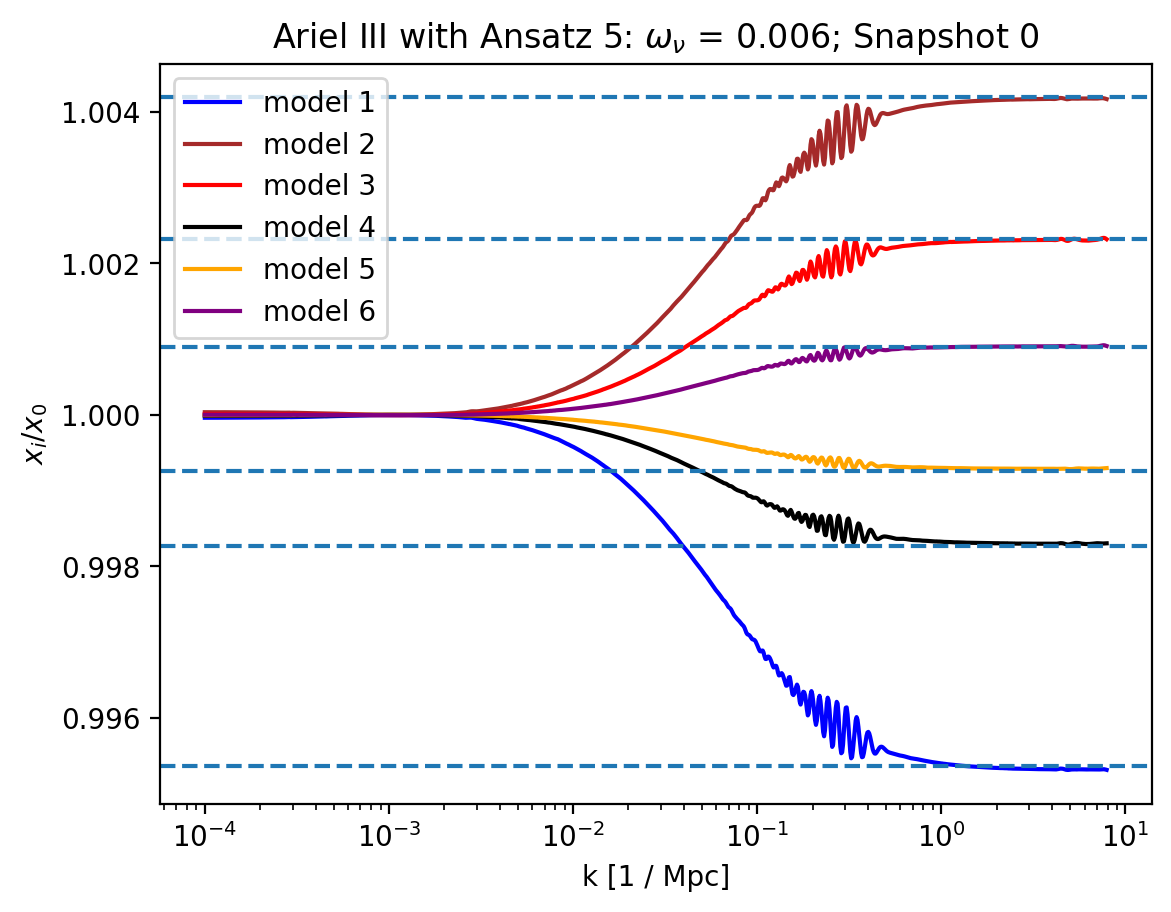

In [33]:
fig, axs = plt.subplots()
spectra.model_ratios_true(snap_index, data, axs,
    massive='x', skips=[7, 8], omnuh2_str=onh2_str,
    title=dTitle + " with Ansatz 5")
for i in range(len(true_asymptotes)):
    axs.axhline(m5 * x5[i] + b5, linestyle='--')

Text(0, 0.5, 'Reduced chi squared goodness of fit')

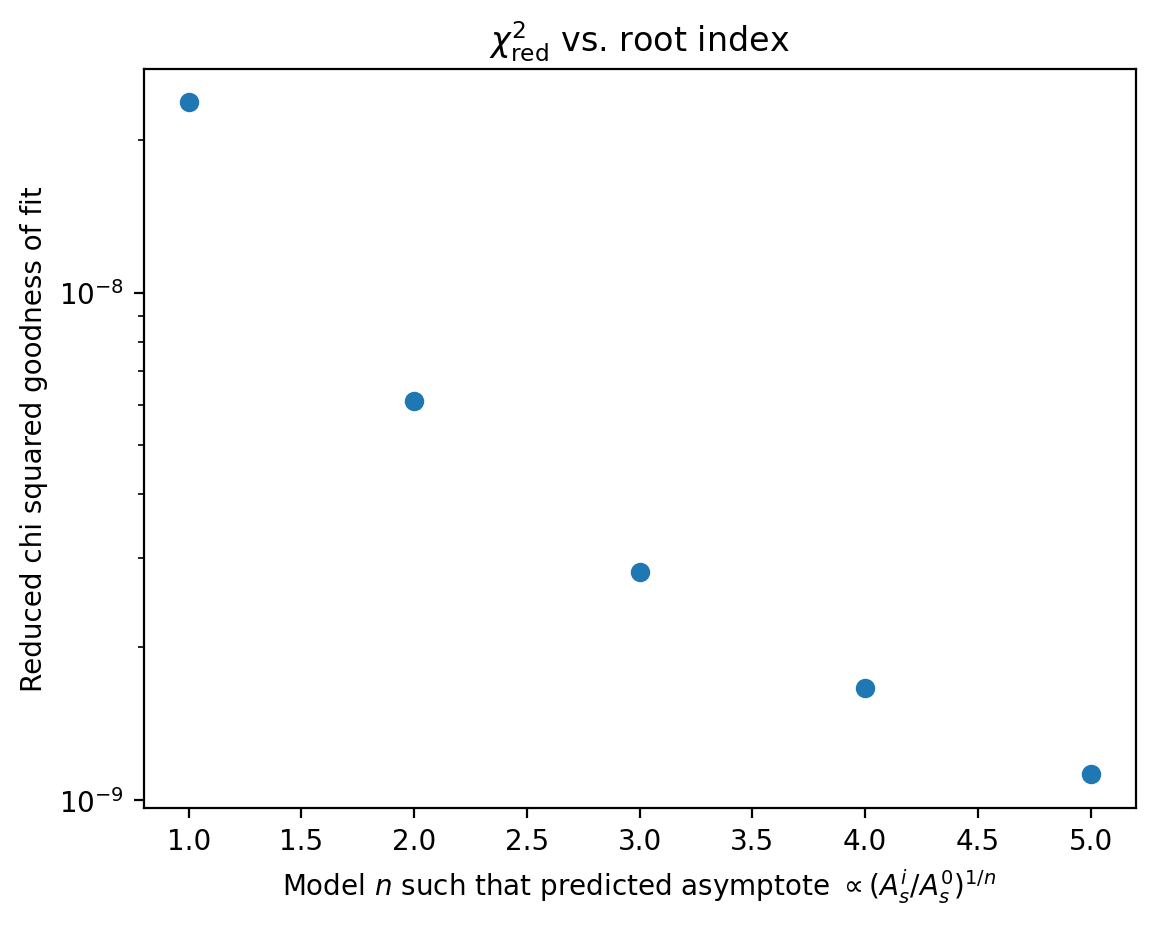

In [34]:
n = np.array(list(range(1, 6)))
red_chisqs = np.array([red_chisq1, red_chisq2, red_chisq3, red_chisq4,
    red_chisq5])
plt.scatter(n, red_chisqs)
plt.yscale('log')
plt.title(r"$\chi_\mathrm{red}^2$ vs. root index")
plt.xlabel(r"Model $n$ such that predicted asymptote " +
           "$\propto (A_s^i / A_s^0)^{1/n}$")
plt.ylabel("Reduced chi squared goodness of fit")

y-intercept for this fit is 1.000003307660056
slope for this fit is 4.20888488348626
Reduced chi squared value for this fit: 1.5344063272020493e-10


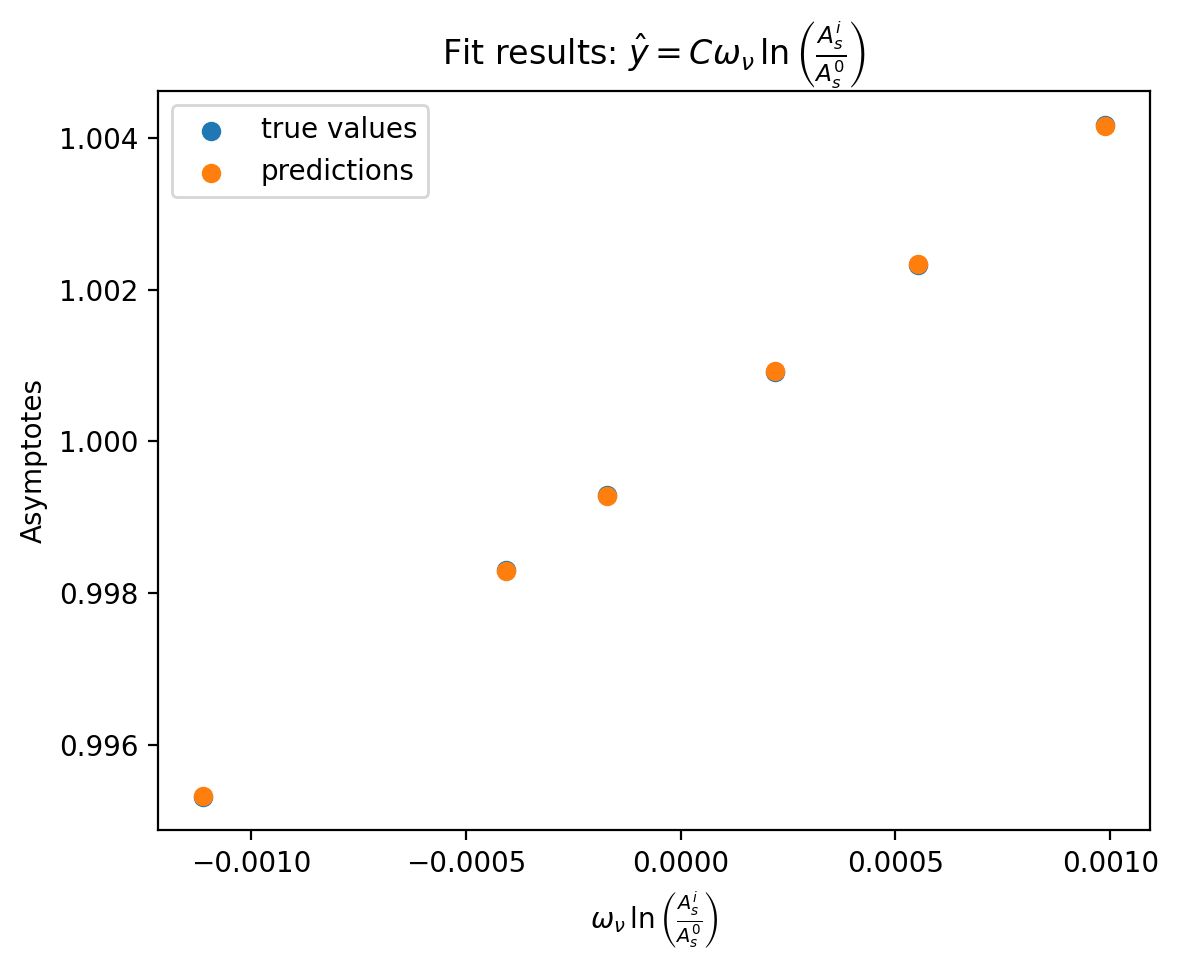

In [35]:
x6 = onh2 * np.log(A_s[1:] / A_s[0])
model_desc_6 = r"\omega_\nu \, \ln \left( \frac{A_s^i}{A_s^0} \right)$"

plt.scatter(x6, true_asymptotes, label="true values")

b6, m6 = polyfit(x6, true_asymptotes, 1)

pred6 = m6 * x6 + b6
plt.scatter(x6, pred6, label="predictions")

print("y-intercept for this fit is", b6)
print("slope for this fit is", m6)

plt.ylabel("Asymptotes")
plt.xlabel("$" + model_desc_6)
plt.title(r"Fit results: $\hat{y} = C" + model_desc_6)
plt.legend()

chis6 = (true_asymptotes - pred6) ** 2 / pred6
red_chisq6 = sum(chis6) / len(x6)
print("Reduced chi squared value for this fit:", red_chisq6)

In [36]:
pred6

array([0.99532116, 1.0041603 , 1.00233201, 0.99829358, 0.99928359,
       1.00092692])

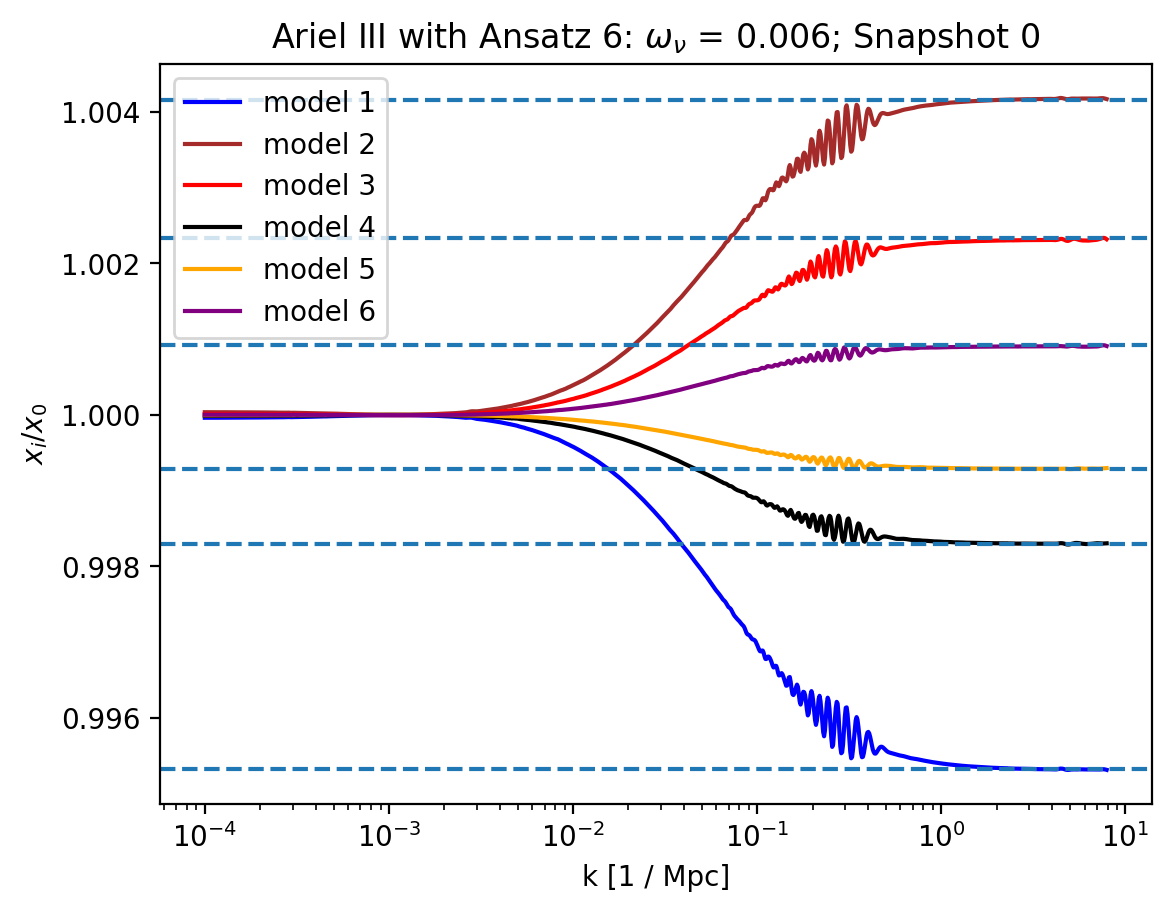

In [37]:
fig, axs = plt.subplots()
spectra.model_ratios_true(snap_index, data, axs,
    massive='x', skips=[7, 8], omnuh2_str=onh2_str,
    title=dTitle + " with Ansatz 6")
#axs.get_legend().remove()
for i in range(len(true_asymptotes)):
    axs.axhline(m6 * x6[i] + b6, linestyle='--')